# Bread - Image Processing

In this tutorial you will learn to measure pores properties in an evolving bread structure.

We are going to analyse 10 croped images of a bread sample from the study [Structural formation during bread baking in a combined microwave-convective oven determined by sub-second in-situ synchrotron X-ray microtomography](https://www.sciencedirect.com/science/article/pii/S0963996923008281?via%3Dihub).

The 5 first images are from the very beginning of the baking (dough state, indexes 1 to 5). The last 5 images are from the very end of the baking process (indexes 6 to 10).

The tutorial is divided in the following sections:
- Import libraries
- Processing folders
- Get familiar with the input data
- Phase segmention
- Cleaning the speckles
- Pore segmentation
- Remove the edge pores
- Summary

## A) Import libraries

In [1]:
from FoamQuant import *
import numpy as np
import skimage as ski 
import os
import matplotlib.pyplot as plt; plt.rc('font', size=20) 
from tifffile import imread, imsave
from scipy import ndimage
import pickle as pkl
import spam

## B) Processing folders

In [29]:
# Processing folders names
ProcessPipeline = ['P1_Raw',
                   'P2_PhaseSegmented',
                   'P3_Cleaned',
                   'P4_PoreSegmented',
                   'P5_PoreNoEdge']
# Create the folders (where we are going to save our results)
for Pi in ProcessPipeline:
    if  os.path.exists(Pi):
        print('path already exist:',Pi)
    else:
        print('Created:',Pi)
        os.mkdir(Pi)

path already exist: P1_Raw
path already exist: P2_PhaseSegmented
path already exist: P3_Cleaned
path already exist: P4_PoreSegmented
path already exist: P5_PoreNoEdge


## C) Get familiar with the input data
Let's read the first and last bread raw images of the series. 

In [3]:
# Name and directory of our raw images
dirraw = 'P1_Raw/'
nameraw = 'Raw_'

# Read the first image of the series
fullname = dirraw+nameraw+strindex(1, n0=3)+'.tif'
print('The full directory+name: ', fullname)
FirstRawIm = imread(fullname)
# Read the last image of the series
fullname = dirraw+nameraw+strindex(10, n0=3)+'.tif'
print('The full directory+name: ', fullname)
LastRawIm = imread(fullname)

The full directory+name:  P1_Raw/Raw_001.tif
The full directory+name:  P1_Raw/Raw_010.tif


/gpfs/offline1/staff/tomograms/users/flosch/Old/PSI_2021_Bread/FoamQuant/Figure.py:90: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


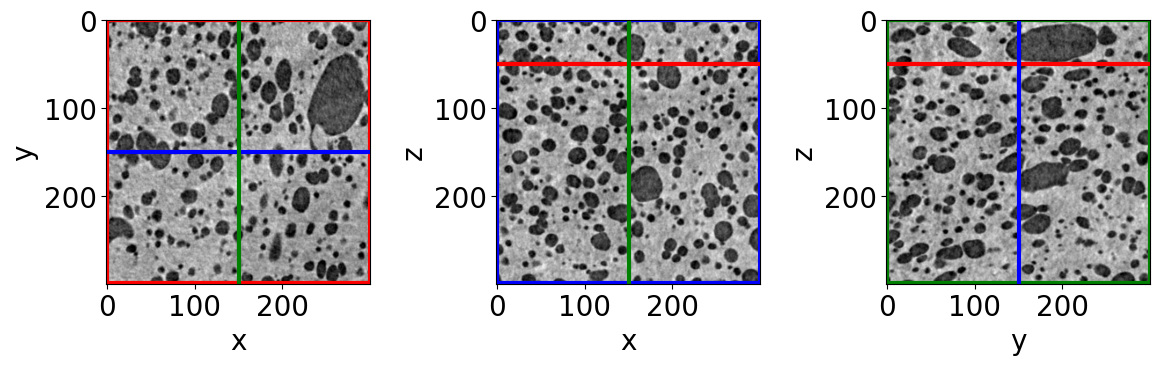

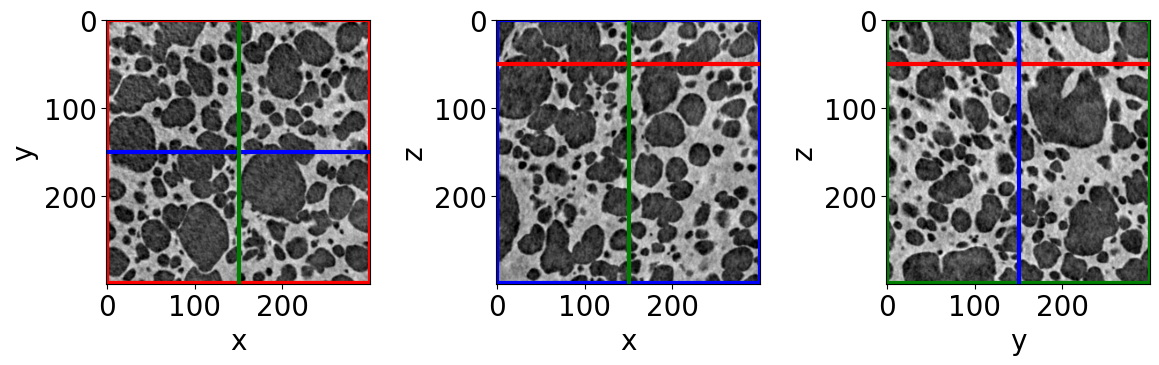

In [4]:
# Show a 3D-cut view of the volume
Cut3D(FirstRawIm, 
      showcuts=True, # Shows the red, blue and green cuts.
      nameaxes=['z','y','x'], # Shows the name of the axes, here z,y,x.
      figblocksize=4,# This parrameter gives the size of the produced figure (here 4*3 along the horizontal,  along the vertical).
      zcut=50,       # The cut position can be tuned here by giving values to the parrameters zcut, ycut or xcut.
      ycut=False,    # By default, the cut is done in the middle of the image.
      cmap='gray')   # The default colormap used by this function is 'gray' but can be modified here.

Cut3D(LastRawIm, 
      showcuts=True, 
      nameaxes=['z','y','x'],
      figblocksize=4,
      zcut=50,       
      ycut=False,    
      cmap='gray')   

Now that we are a bit more familiar with what we are going to work with let's start with the first step, the **phase segmentation**

## D) Phase segmentation
Here, our objective is to separate (indentify) the pixels that corresponds either to the solid phase or the gas phase (the pores). 
    Phase-segmentation means assigning to each pixel/voxel a phase-label: '0' for the solid continuous matrix, and '1' for the gas pore volumes.

**Thresholding the image, a method adapted to our simple two-phase system**

They are many ways an image can be segmented. In our case, we are lucky. Bread (such as liquid or solid foams) is made of only two phases (solid and gas), and with two very distinct electron densities. 
    This makes foam a faily easy stucture to segment with a unique threshold value. This means that we independently compare each individual pixel grey-value with a single threshold. If it is larger, we assign it to one phase (solid), and on the other hand we assign it to the other phase (gas). This threholding method is very common and can even be used to segment images having more than two phases.

**Little exercise: manual threshold the first image of our time-series**

Let's observe the gray-value distribution of our first image, and based on it, let's try to manually threshold our first image.
    The following figure shows you how the left-hand side picture is threholded with the threhold manual_thr. 
    Play with this parrameter and observe how the histogram is swipped. Does the right-hand side picture looks "good"? Change the threshold value until it look "satisfying".

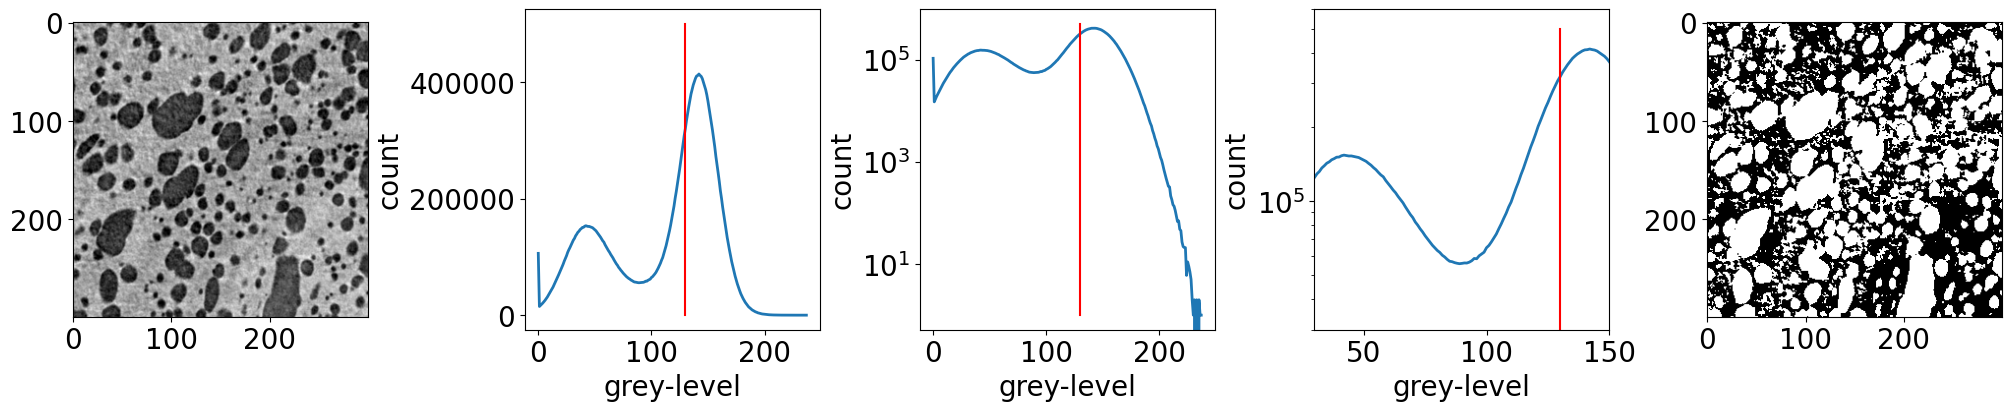

In [5]:
# Manual threholding value (play with this value and re-run this cell)
manual_thr = 130

# Figure
hist, hist_centers = ski.exposure.histogram(FirstRawIm) # gray-value histogram
fig, axes = plt.subplots(1, 5, figsize=(5*4, 4), constrained_layout=True)

axes[0].imshow(FirstRawIm[125], cmap='gray') # image before thresholding

# histograms
for axi in range(1,4):
    axes[axi].plot(hist_centers, hist, lw=2)
    axes[axi].set_xlabel('grey-level')
    axes[axi].set_ylabel('count')
    axes[axi].plot([manual_thr,manual_thr],[1,5e5],'r')
axes[2].set_yscale('log')
axes[3].set_yscale('log')
axes[3].set_xlim(30,150)
axes[3].set_ylim(3e4,6e5)

axes[4].imshow(FirstRawIm[125]<manual_thr, cmap='gray') # image after thresholding

With this little exercise, you might realise two things. First, doing this for every individual picture of a time serie is time consuming. Second, and most importantly, manually choosing a threshold may be a problem for reproducibility of your results. You might choose a threshold value, but you neighboor might choose another one! How to be consistent? Is there a method that could give us a reproducible thresholding result? 

The answer is yes! There are many thresholding methods and if you are currious about them, have a look on the scikit-image website:
[scikit-image - Thresholding guide](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html) 
However, keep in mind that by choosing a method, you also in a way introduce a bias in the rest of your quantification pipeline. The selected method will have an effect on the segmentation result. This is why, one often perform sensitivity tests or compare methods in order to increase our confidence in the downstream quantifications. The most important is to be clear and transparent on your choices.

**The Otsu's method**

One classical thresholding methods is called the Otsu's method, named after Nobuyuki Otsu [Wikipedia - Otsu's method](https://en.wikipedia.org/wiki/Otsu's_method). 
It is an algorithm that returns a threshold that separate optimaly the pixels grey-values into two classes (here corresponding to our two phases). It does this by finding the optimal intra-class variance. The foamquant function we are going to use, **PhaseSegmentation_Batch**, simply wrapps up many segmentation functions already available in the scikit-image library, including the Otsu's method [scikit-image - Otsu](https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.otsu).

We are going to use a "Batch" function that will process our whole time serie in one go: **PhaseSegmentation_Batch**. This function basically apply the **PhaseSegmentation** function inside a loop, load and save the result image at the given directory.

In [6]:
# Name and directory where we want to save our phase segmented images
dirphaseseg = 'P2_PhaseSegmented/'
namephaseseg = 'PhaseSegmented_'

# Indexes of the images of our time-series (we are working here with 10 subsequent images of the same foam sample, evolving over time).
imrange = [1,2,3,4,5,6,7,8,9,10]

# Otsu simple threshold phase segmentation of the whole series
Otsu_th =PhaseSegmentation_Batch(nameraw, namephaseseg,
                        dirraw, dirphaseseg,
                        imrange,
                        method='ostu_global',
                        returnOtsu=True,
                        verbose=True,
                        n0=3,
                        endread='.tif',
                        endsave='.tif')

# Print the threshold values
print('The 10 Otsu thresholds that were used to segment our 10 images:\n',np.asarray(Otsu_th))

PhaseSegmented_ 1: done

PhaseSegmented_ 2: done

PhaseSegmented_ 3: done

PhaseSegmented_ 4: done

PhaseSegmented_ 5: done

PhaseSegmented_ 6: done

PhaseSegmented_ 7: done

PhaseSegmented_ 8: done

PhaseSegmented_ 9: done

PhaseSegmented_ 10: done

The 10 Otsu thresholds that were used to segment our 10 images:
 [93 93 94 94 94 94 94 94 94 94]


How does these values look compared to what you got manually?
Let's have a look at the first image of the serie, before and after this automated phase-segmentation.

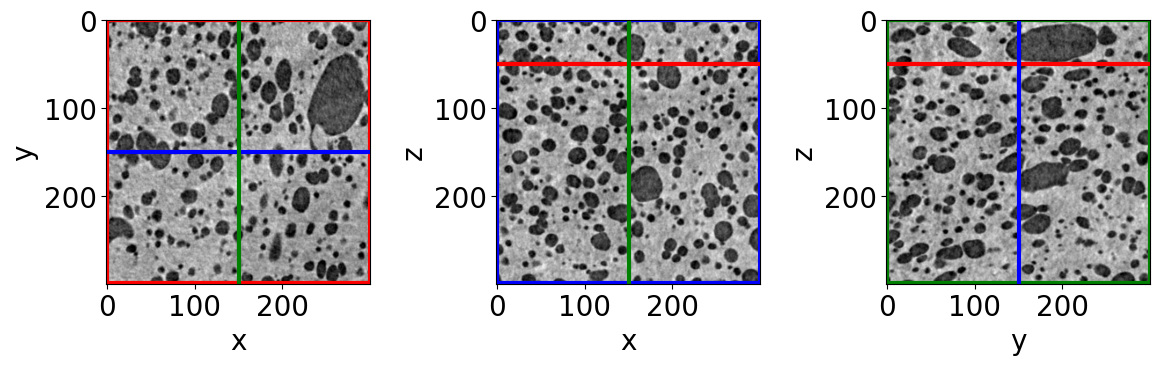

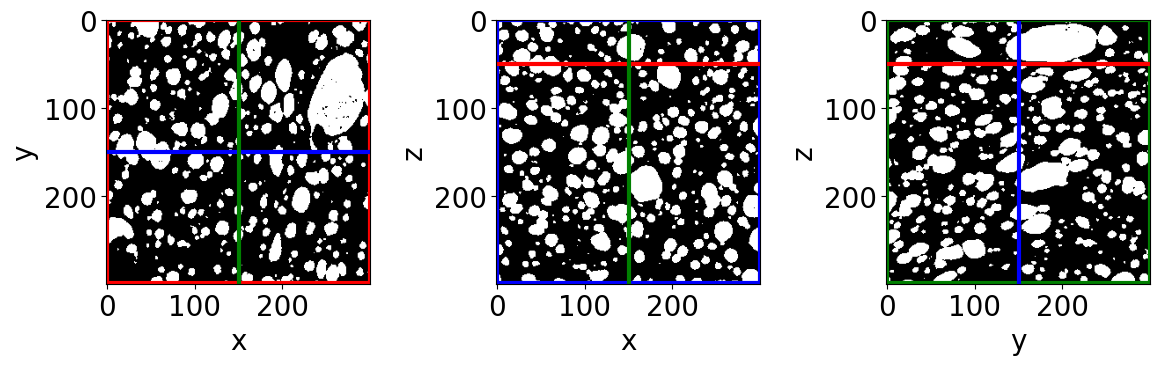

In [7]:
# read the first phase-segmented image of the serie
FirstSegIm = imread(dirphaseseg+namephaseseg+strindex(1, n0=3)+'.tif')

# raw image orthogonal cuts figure
Cut3D(FirstRawIm, 
      showcuts=True, 
      nameaxes=['z','y','x'], 
      figblocksize=4,
      zcut=50,       
      ycut=False,    
      cmap='gray')

# phase-segmented image orthogonal cuts figure
Cut3D(FirstSegIm, 
      showcuts=True, 
      nameaxes=['z','y','x'], 
      figblocksize=4,
      zcut=50,       
      ycut=False,    
      cmap='gray')

Let's have a closer look

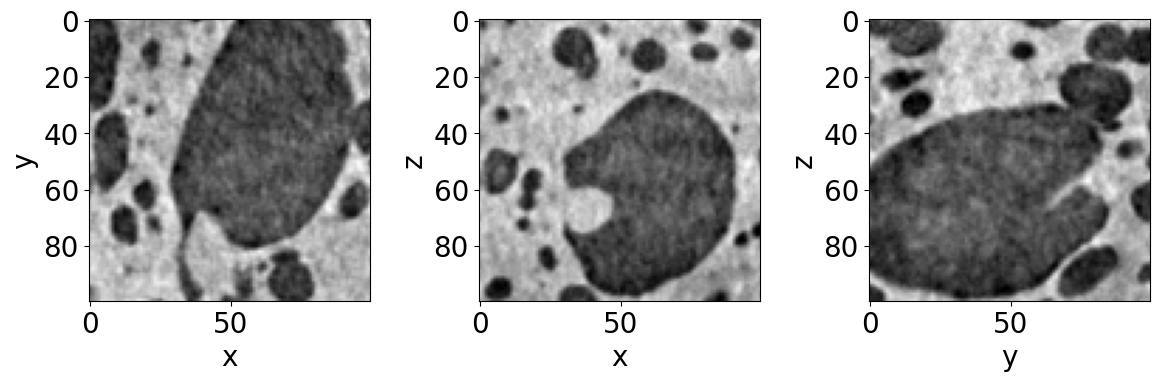

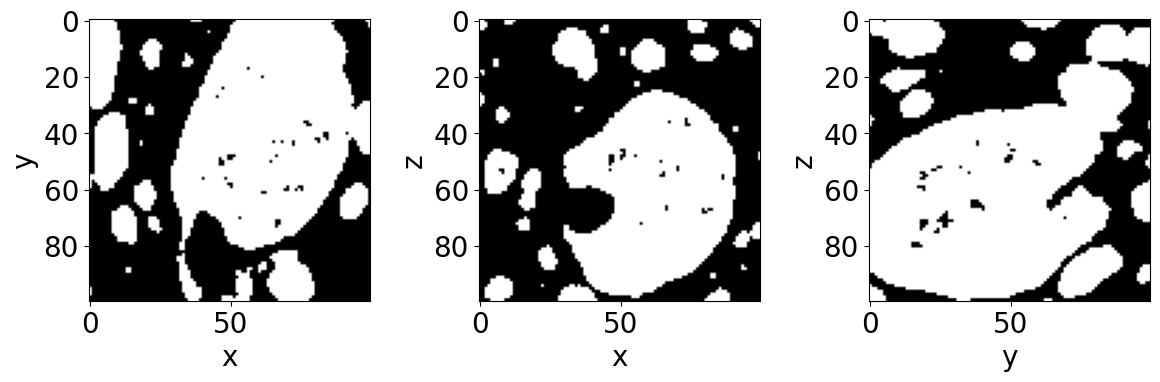

In [8]:
# the same as above, just done on cropped volumes 
Cut3D(FirstRawIm[0:100,50:150,200:300], 
      nameaxes=['z','y','x'],
      figblocksize=4)

Cut3D(FirstSegIm[0:100,50:150,200:300], 
      nameaxes=['z','y','x'],
      figblocksize=4)

Can you see the black voxel in the very middle of this pore? 
These voxels are definitively not corresponding to the solid phase, and still is assigned a '0' value. These artefacts (speckles) are common when using a thresholding segmentation method, and are often due to noise in the raw image. Can you see the slighty brighter voxels in the corresponding raw image?

## E) Cleaning the speckles
In this section, we are going to clean our phase-segmented images from speckles artefacts.
Black and white speckles are often refered as holes and objects respectively. 

Once again we are going to run this procedure to the whole time serie with the "Batch" function **RemoveSpeckleBin_Batch**. 
Again, it is just wrapping some scikit-image functions. If you want more information on the **remove_objects** function, have a look here [scikit-image - Remove objects](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_remove_objects.html).

**RemoveSpeckleBin_Batch** remove all the spekles (starting with the objects, then with the holes) with the following criteria:


$V_{obj} \leq C_{obj}  \max(V_{obj}(t=0))$

$ V_{hole} \leq C_{hole}  \max(V_{hole}(t=0))$


With $V_{obj}$ and $V_{hole}$ the volume of any connected object or holes. $C_{obj}$ and $C_{hole}$ are two coefficients one has to fix.
The maximum volumes are only estimated in the first image and then reused for the rest of the time series.

Once again, prior knowledge on what we are looking at helps us in this cleaning work. Bread is made of a contunious solid phase inside of which we have a discontinuous gas phase (the pores). We do not have any knowledge on the smallest pore the bread stucture can contain. We choose therefore to keep the smallest pore regions, but keep in mind these can be physical but also just do to noise. In practice, to be conservative in our later quantification method the pore having a volume below 3x3x3 = 27 voxels should be disregarded. 

Therefore, we will remove the holes with a large value $C_{hole}$, but keep $C_{obj} = None$ to keep the small objects as it is. 

In [10]:
# Name and directory where we want to save our cleaned images
dircleaned = 'P3_Cleaned/'
namecleaned = 'Cleaned_'

# remove holes and objects
RemoveSpeckleBin_Batch(namephaseseg, 
                       namecleaned, 
                       dirphaseseg, 
                       dircleaned, 
                       imrange, 
                       verbose=True, 
                       endread='.tif', 
                       endsave='.tif', 
                       n0=3, 
                       RemoveObjects=False,
                       Chole=0.1) # tune this parrameter if you wish

Before: Nobj 6104
After: Nobj 1
Before: Nhol 983
After: Nhol 1
First image (vox): maxObj 4987372 maxHole 22006312
Thresholds (vox): thrObj 2493686 thrHole 2200631 

Before: Nhol 1316
After: Nhol 1
Cleaned_001: done

Before: Nhol 1283
After: Nhol 1
Cleaned_002: done

Before: Nhol 1212
After: Nhol 1
Cleaned_003: done

Before: Nhol 1384
After: Nhol 1
Cleaned_004: done

Before: Nhol 1418
After: Nhol 1
Cleaned_005: done

Before: Nhol 1868
After: Nhol 1
Cleaned_006: done

Before: Nhol 1945
After: Nhol 1
Cleaned_007: done

Before: Nhol 1878
After: Nhol 1
Cleaned_008: done

Before: Nhol 1928
After: Nhol 1
Cleaned_009: done

Before: Nhol 2064
After: Nhol 1
Cleaned_010: done



Let's see if it worked, is the black speckle still here?

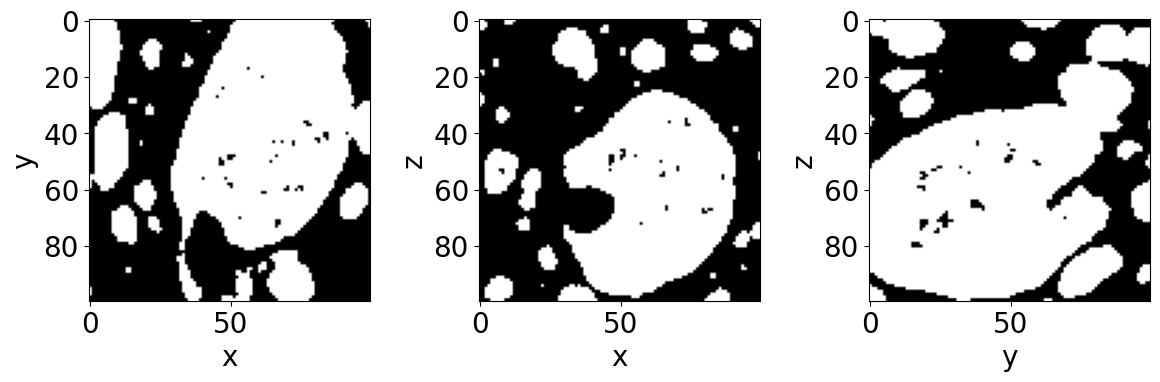

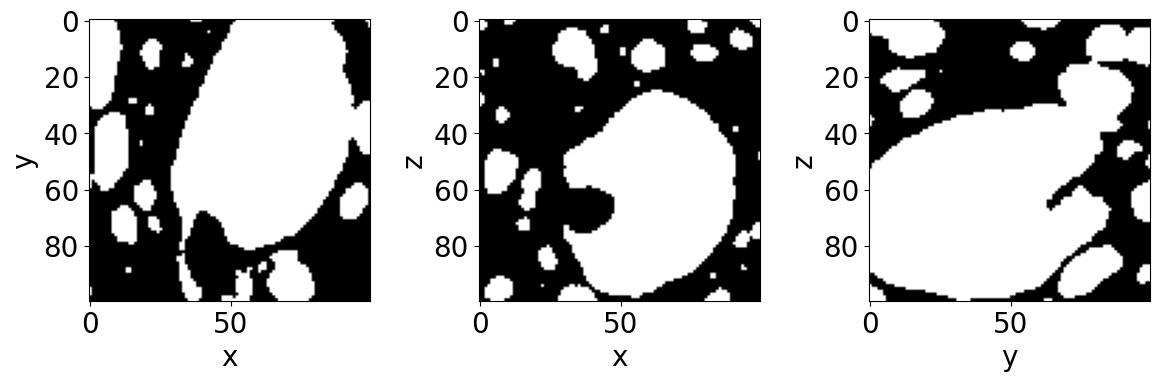

In [12]:
# read the first cleaned image of the serie
FirstCleanedIm = imread(dircleaned+namecleaned+strindex(1, n0=3)+'.tif')

# phase-segmented image orthogonal cuts figure
Cut3D(FirstSegIm[0:100,50:150,200:300], 
      nameaxes=['z','y','x'],
      figblocksize=4)

# cleaned image orthogonal cuts figure
Cut3D(FirstCleanedIm[0:100,50:150,200:300], 
      nameaxes=['z','y','x'],
      figblocksize=4)

Pretty good!

We are now ready for the next step, another segmentation: the pore segmentation.

## F) Pore segmentation
solid foam is made of gas pores in close contact, resulting effectively in a discontinuous gas phase dispersed inside a continuous solid matrix.

There are many methods to segment regions based on geometrical criteria [scikit-image - Segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#module-skimage.segmentation). Fortunately, a classical segmentation method called **watershed** is perfectly adaped to our problem. It allows to segment adjacent regions (such as touching/overlapping spheres) based on a propagation of labels (integers) from seeds. These seeds in our images are identified as the maximum distance peaks inside the gas-phase (white region) from any solid-phase voxels (black region).

Let's start by performing this segmentation manually, step by step, to understand how it works.

**Little exercice: understading the step-by-step watershed segmentation on the first image of the series**

Try to read though the following code-cell. Do not hesitate to modify parrameters and run again this cell to see what it changes in the resulting pore-segmented image.

As mentionned above, for the small pore regions (1, white), they may be speckle artefacts or actual pores in the bread. Therefore they are not going to be filtered. All the pore having a volumes below 3x3x3=27 voxels should be disgarded because of the this resolution limitation.

In [15]:
# Let's work with a subvolume of the first cleaned image, to see more closely what is happening
ExerciseImage = FirstCleanedIm[0:100,50:150,200:300]

# We start by computing the distance-map: 
# For each white voxel, the Euclidean distance to the closest black voxel is computed. 
# The returned result is what we call a distance-map, an image containing all these distance measures saved in form of an image.
Distmap = ndimage.distance_transform_edt(ExerciseImage)

# The distance-map maximums are effectively the voxels being the further away from any black voxel surrounding it. 
# Since the pores are quite spherical, each of the pore have in their volume like a "distance-map conical mount". 
# The mount might however not have a unique maximum. It can be a like a young mountain, sharp with many smaller peaks at its top. 
# We however want to identify one pore for a given "moun" and not each of these "peaks". 
# A simple way to resolve this problem is by "erroding a bit these mounts". We are going to smooth them with a Gaussian filter, with the standard deviation kernel sigma=2.
SmoothDistmap = ski.filters.gaussian(Distmap, sigma=2)

# Find the maximum from the smoothed distance map, including the maximum at the edge of the image
local_max_coord = ski.feature.peak_local_max(SmoothDistmap, exclude_border=False)

# Create a '0'-background image filled with '1' where the maximums are.
local_max_im = np.zeros(np.shape(ExerciseImage))
for locmax in local_max_coord:
    local_max_im[locmax[0],locmax[1],locmax[2]] = 1
# Then label each of these '1' voxels by assigning them a integer label ("name"): '1','2','3',...,'N'
local_max_im_labelled = ndimage.label(local_max_im)[0]

# Apply the watershed algorithm that will fill up ("with water") the flipped smoothed distance map landscape from the local-max "sources-points" (also called seeds), 
# thi until the whole image is filled. Each puctual label is spread and at the end every pore (if it worked well) is filled with a region made of a unique label.
labelled_im = ski.segmentation.watershed(image = -SmoothDistmap, 
                                         markers = local_max_im_labelled, 
                                         mask = ExerciseImage, 
                                         watershed_line=False)

Text(0.5, 1.0, 'Pore segmented')

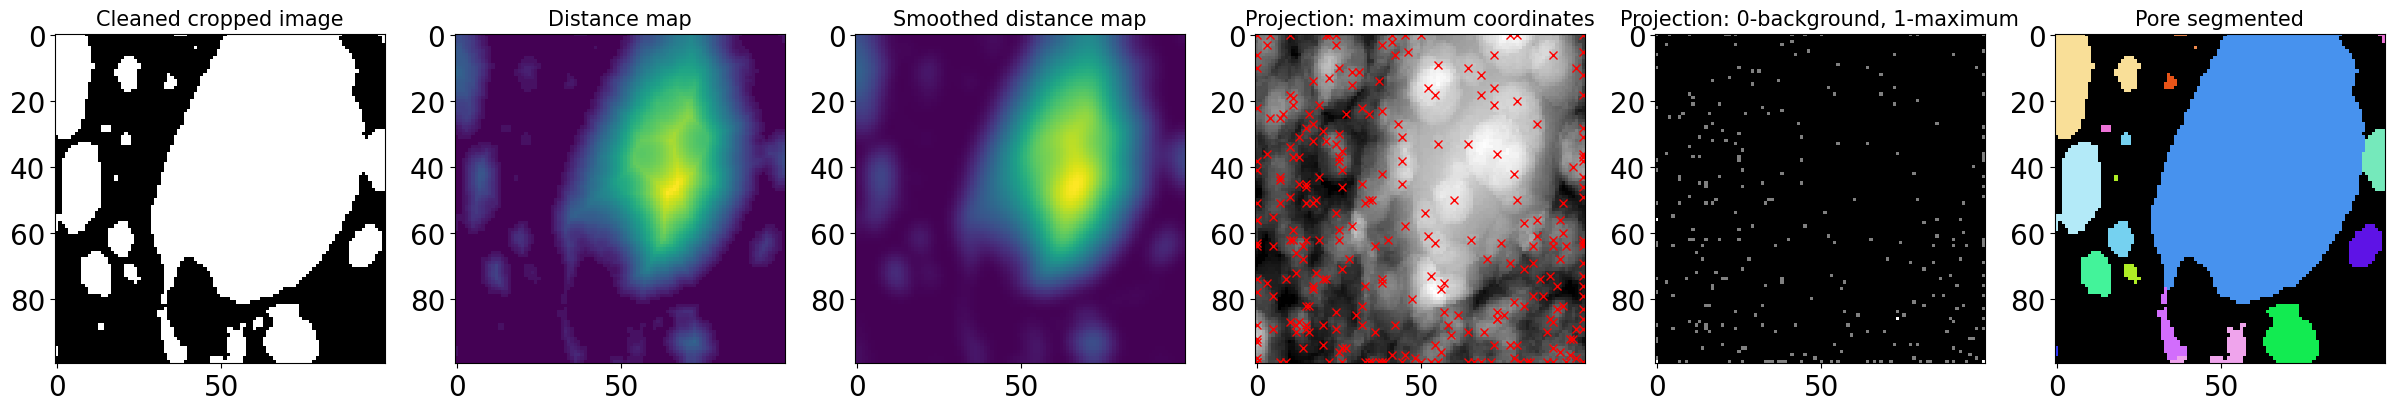

In [19]:
fig, axes = plt.subplots(1, 6, figsize=(6*4, 4), constrained_layout=True)

# First cleaned image (z-cross-section at z = 25 vox)
axes[0].imshow(ExerciseImage[50], cmap='gray')
axes[0].set_title('Cleaned cropped image', fontsize=15)

# Distance map (z-cross-section at z = 25 vox)
axes[1].imshow(Distmap[50], cmap='viridis')
axes[1].set_title('Distance map', fontsize=15)

# Smoothed distance map (z-cross-section at z = 25 vox)
axes[2].imshow(SmoothDistmap[50], cmap='viridis')
axes[2].set_title('Smoothed distance map', fontsize=15)

# Projection view of the cleaned image with the identified maximums
axes[3].imshow(np.sum(ExerciseImage,0), cmap='gray')
for coord in local_max_coord:
    axes[3].plot(coord[2],coord[1],'xr')
axes[3].set_title('Projection: maximum coordinates', fontsize=15)

# Projection view of the 0-background / 1-maximum image
axes[4].imshow(np.sum(local_max_im,0), cmap='gray')
axes[4].set_title('Projection: 0-background, 1-maximum', fontsize=15)

# Create a random colormap to see the different pores
rcmap = RandomCmap(100,verbose=False)
# pore-segmented image (z-cross-section at z = 25 vox)
axes[5].imshow(labelled_im[50], cmap=rcmap)
axes[5].set_title('Pore segmented', fontsize=15)

**Run pore-segmentation on the whole time-series**

Now that we understand a bit more how the watershed segmentation works, and see which parrameters works well, we can go back to our time serie and process it in one go with the **BubbleSegmentation_Batch** function. It wraps-up the steps shown above with some more parrameters, for example for the filtration of the seeds or the type of watershed. It also include the ITKwatershed included in the SPAM package [SPAM - ITKwatershed](https://www.spam-project.dev/docs/spam.label.html#module-spam.label.ITKwatershed). Try **help(BubbleSegmentation_Batch)** if you want to see and try them.

In [21]:
# Name and directory where we want to save our bubble-segmented images
dirporeseg = 'P4_PoreSegmented/'
nameporeseg = 'PoreSeg_'

# Segment the pores with default parrameters 
# for more parrameters, try help(BubbleSegmentation_Batch)
BubbleSegmentation_Batch(namecleaned, 
                         nameporeseg, 
                         dircleaned, 
                         dirporeseg, 
                         imrange, 
                         verbose=True, 
                         endread='.tif', 
                         endsave='.tif', 
                         ITK = True,   #Use the ITK watershed from SPAM
                         Binning = 1,  #To reduce the run-time, one can chose to bin the image, if bin=2 every block of 2x2x2 voxels -> 1 voxel
                         n0=3)

Path exist: True
PoreSeg_001: done

PoreSeg_002: done

PoreSeg_003: done

PoreSeg_004: done

PoreSeg_005: done

PoreSeg_006: done

PoreSeg_007: done

PoreSeg_008: done

PoreSeg_009: done

PoreSeg_010: done



To distinguish each individual pore in the image, we are going to use a random color map. It has by default a black background and here we choose to extend it in the range of 1 to 5000 integer values.

Number of labels: 5000


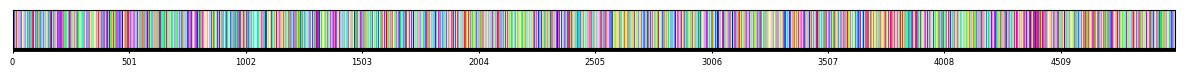

In [22]:
# Since we are now looking at more pores let's create a "larger" random colormap: here 5000 random colors
rcmap = RandomCmap(5000)

Let's read the first pore-segmented (also called labelled) image of the series. 

How do the pores look like? Are they "well" segmented? 
It is possible to have over- or under-segmentation of the pores, i.e. a too fine or too coarse segmentation of their volumes.
This is due to the finding of too many or too few local maximum in the distance map. It can be sometimes tricky to remove absolutely all of them, and we will see in a next tutorials (Region properties and Tracking) how to disregard them. 

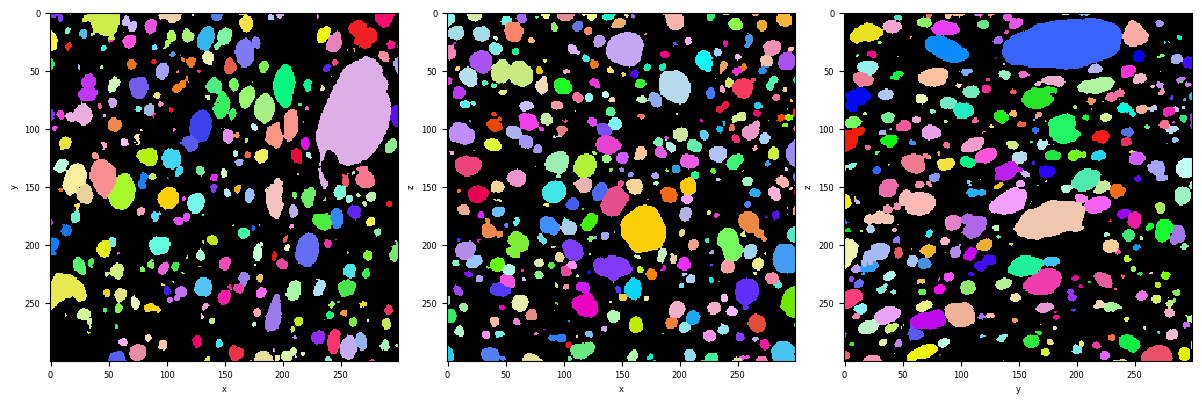

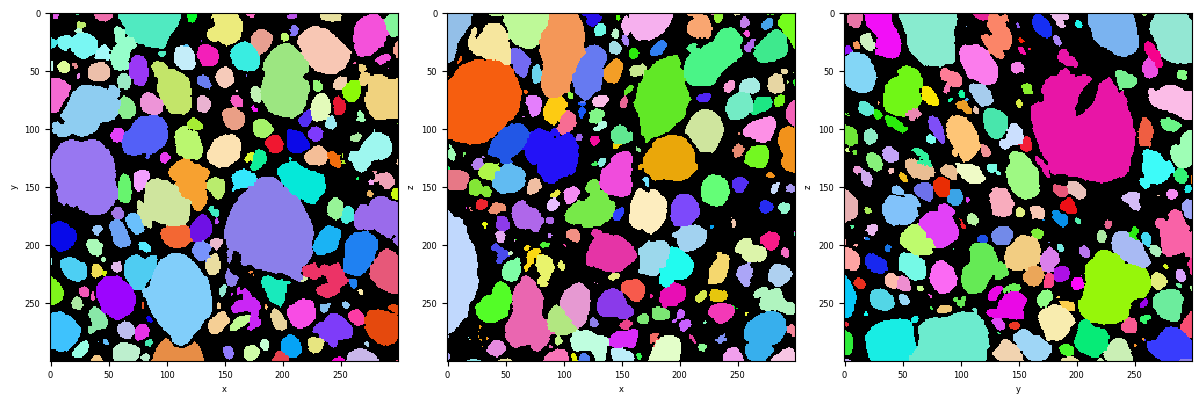

In [26]:
# Read the first image of the series
Lab = imread(dirporeseg+nameporeseg+strindex(1, 3)+'.tif')
# Show a 3D-cut view of the volume
Cut3D(Lab,  
      nameaxes=['z','y','x'],
      cmap=rcmap, 
      interpolation='nearest', 
      figblocksize=4,
      zcut=50)

# Read the filast image of the series
Lab = imread(dirporeseg+nameporeseg+strindex(10, 3)+'.tif')
# Show a 3D-cut view of the volume
Cut3D(Lab,  
      nameaxes=['z','y','x'],
      cmap=rcmap, 
      interpolation='nearest', 
      figblocksize=4,
      zcut=50)

## G) Remove the edge pores 

The pores at the edges of the images are irrelevant for further quantifications. They are "cut" so for exampe have a smaller volume than in reality. To resolve this problem, we decide to remove these labels from our images when at least one of their voxel touch the edge of the image.

In [27]:
# Name and directory where we want to save our pore-no-edge images
dirnoedge = 'P5_PoreNoEdge/'
namenoedge = 'PoreNoEdge_'

RemoveEdgeBubble_Batch(nameporeseg, 
                       namenoedge, 
                       dirporeseg, 
                       dirnoedge, 
                       imrange, 
                       verbose=True, 
                       endread='.tif', 
                       endsave='.tif', 
                       n0=3,  
                       Masktype=[False,False])

Path exist: True
PoreNoEdge_001: done

PoreNoEdge_002: done

PoreNoEdge_003: done

PoreNoEdge_004: done

PoreNoEdge_005: done

PoreNoEdge_006: done

PoreNoEdge_007: done

PoreNoEdge_008: done

PoreNoEdge_009: done

PoreNoEdge_010: done



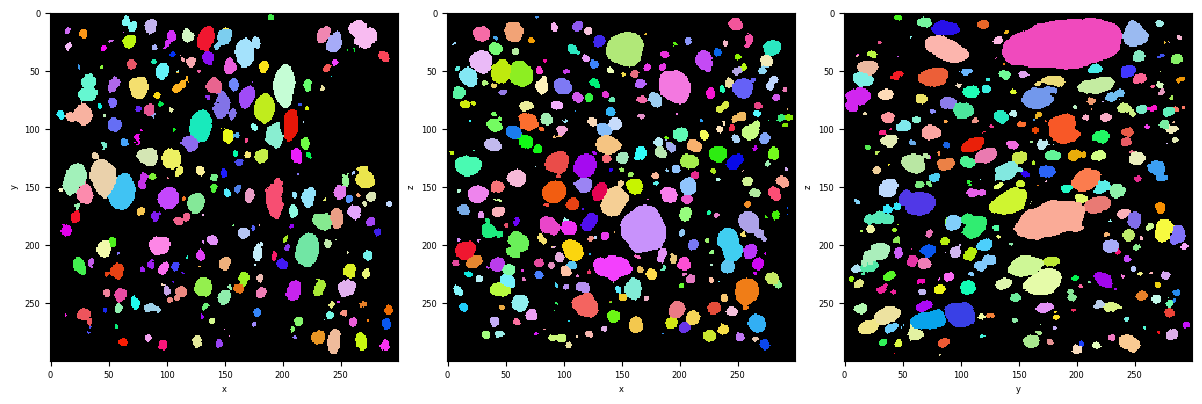

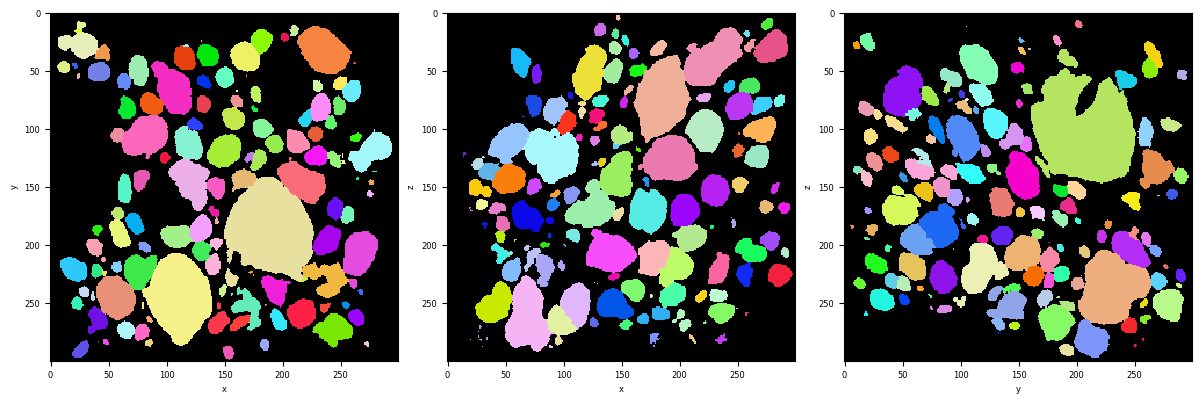

In [28]:
# Read the first image of the series
Lab = imread(dirnoedge+namenoedge+strindex(1, 3)+'.tif')
# Show a 3D-cut view of the volume
Cut3D(Lab,  
      nameaxes=['z','y','x'],
      cmap=rcmap, 
      interpolation='nearest', 
      figblocksize=4,
      zcut=50)

# Read the filast image of the series
Lab = imread(dirnoedge+namenoedge+strindex(10, 3)+'.tif')
# Show a 3D-cut view of the volume
Cut3D(Lab,  
      nameaxes=['z','y','x'],
      cmap=rcmap, 
      interpolation='nearest', 
      figblocksize=4,
      zcut=50)

## H) Summary

Let's now quickly summarize the processing steps we have done and have by the same occasion a chek on the whole time-series.

**CutSerie** is an interesting tool to plot the cross-section of an image over time. Indicate the directory, the name of your image and the range of index.

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/offline1/staff/tomograms/users/flosch/Old/PSI_2021_Bread/P1_Raw/Raw_001.tiff'

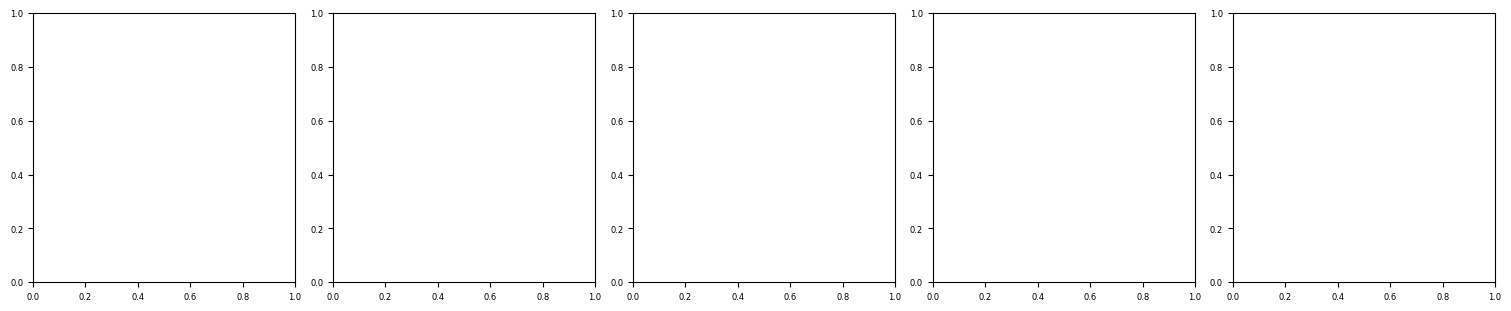

In [30]:
selectrange = imrange[0:10:2]

CutSerie(directory = 'P1_Raw/',
         name = 'Raw_',
         imrange=selectrange, 
         figblocksize=3, 
         title='Raw_',
         Ncolumns=len(selectrange))

CutSerie(directory = 'P2_PhaseSegmented/',
         name = 'PhaseSegmented_',
         imrange=selectrange, 
         figblocksize=3, 
         title='PhaseSegmented_',
         Ncolumns=len(selectrange))

CutSerie(directory = 'P3_Cleaned/',
         name = 'Cleaned_',
         imrange=selectrange, 
         figblocksize=3, 
         title='Cleaned_',
         Ncolumns=len(selectrange))

CutSerie(directory = 'P4_PoreSegmented/',
         name = 'PoreSeg_',
         imrange=selectrange, 
         figblocksize=3, 
         title='PoreSeg_',
         Ncolumns=len(selectrange), 
         cmap=rcmap)

CutSerie(directory = 'P5_PoreNoEdge/',
         name = 'PoreNoEdge_',
         imrange=selectrange, 
         figblocksize=3, 
         title='PoreNoEdge_',
         Ncolumns=len(selectrange), 
         cmap=rcmap)

You have now completed this bread image processing tutorial. I hope it has been helpfull to you. Go back to [FoamQuant - Examples](https://foamquant.readthedocs.io/en/latest/examples.html) for more examples and tutorials. The one on bread image quantification might be interesting to you!